In [1]:
import pandas as pd

In [2]:
# df = pd.read_csv('../data/sales.csv')
df = pd.read_csv('sales.csv')

In [3]:
df.dropna(subset=['price'], inplace=True)

In [4]:
df.head() 

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [5]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015] 
test_raw = df[df.year >= 2015] 

# 1. Pearson Correlation

<font color='red'>Assignment:</font> Get a Dataframe **train** which contains all the numerical values of **price**, **cost**, **weight**, **height**, **width**, and **depth** in **train_raw**.

In [6]:
train = pd.DataFrame(columns = ['price', 'cost', 'weight', 'height', 'width', 'depth'])

In [7]:
train['price'] = train_raw['price'].map(lambda x: x if type(x) is float else float(x.strip('$').replace(',', '')))

In [8]:
train['cost'] = train_raw['cost'].map(lambda x: x if type(x) is float else 1000*float(x.strip('$').strip('k')))

### the given weight2num function is wrong

In [9]:
def weight2num(st):
    '''
    Transform weigth string to numerical value
    '''
    if type(st) == str:
        st = st.strip("Kg").replace(" ", "").split("Ton")
        return float(st[0])*1000 + float(st[1])
    else:
        return st

train['weight'] = train_raw['weight'].map(weight2num)

In [10]:
train['height'] = train_raw['height'].map(lambda x: x if type(x) is float else float(x.strip(' meters')))

In [11]:
train['width'] = train_raw['width'].map(lambda x: x if type(x) is float else float(x.strip(' cm')))

In [12]:
train['depth'] = train_raw['depth'].map(lambda x: x if type(x) is float else float(x.strip(' cm')))

In [13]:
train.head()

,price,cost,weight,height,width,depth
0,300492.0,333000.0,3090.0,2.76,97.0,26.0
1,430570.0,NaN,3030.0,2.67,98.0,26.0
2,213070.0,270000.0,3040.0,3.00,93.0,24.0
4,122659.0,97000.0,2970.0,2.47,101.0,26.0
5,60320.0,59000.0,2930.0,2.71,96.0,25.0


<font color='red'>Assignment:</font> Calculate Pearson correlations between all the columns in **train**. Using **DataFrame.corr()**.

In [14]:
train_corr = train.corr(method = 'pearson')

<font color='red'>Question:</font> How Pearson correlation is calcualted? What does it mean?

In [15]:
train_corr

,price,cost,weight,height,width,depth
price,1.000000,0.618253,0.301362,0.088917,0.074010,0.076007
cost,0.618253,1.000000,0.347582,0.092488,0.101852,0.103242
weight,0.301362,0.347582,1.000000,0.175936,0.358753,0.349840
height,0.088917,0.092488,0.175936,1.000000,-0.848096,-0.833685
width,0.074010,0.101852,0.358753,-0.848096,1.000000,0.979237
depth,0.076007,0.103242,0.349840,-0.833685,0.979237,1.000000


### $\frac{cov(X, Y)}{\sigma_{X}\sigma_{Y}}$
### If the correlation value is 1, it means that the relation between X and Y is linear and Y increases as X increases.
### If the value is -1, it means the relation X and Y is linear, however, Y decrases as X increases.
### If the value is 0, it means that there is no linear relation between X and Y.

<br>![image](http://1algo1week.warriorkitty.com/assets/pearson-correlation-coefficient/pearson-formula.png)
<br>![image](https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png)

![image.png](attachment:image.png)

### I have question: I read "The use of mean and standard deviation in the calculation suggests the need for the two data samples to have a Gaussian or Gaussian-like distribution." However, from a previous notebook, we learnt that some of these features are log-normal or show skews. Can we still apply df.corr() to train before transforming the data?

### <font color='red'>A:</font> yes, you can always apply, but the number may not make sense. p value.

In [16]:
from scipy.stats import pearsonr
pearsonr(train['price'].fillna(train['price'].mean()), train['cost'].fillna(train['cost'].mean()))

(0.553216127007565, 7.409844703198453e-221)

<font color='red'>Assignment:</font> Plot the correlations in heatmap using **seaborn**.

In [17]:
import seaborn as sns

<AxesSubplot:>

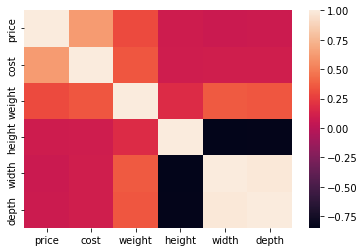

In [18]:
sns.heatmap(train_corr)

<font color='red'>Assignment:</font> Visulize the relationships between these columns using **pairplot** in **seaborn**.

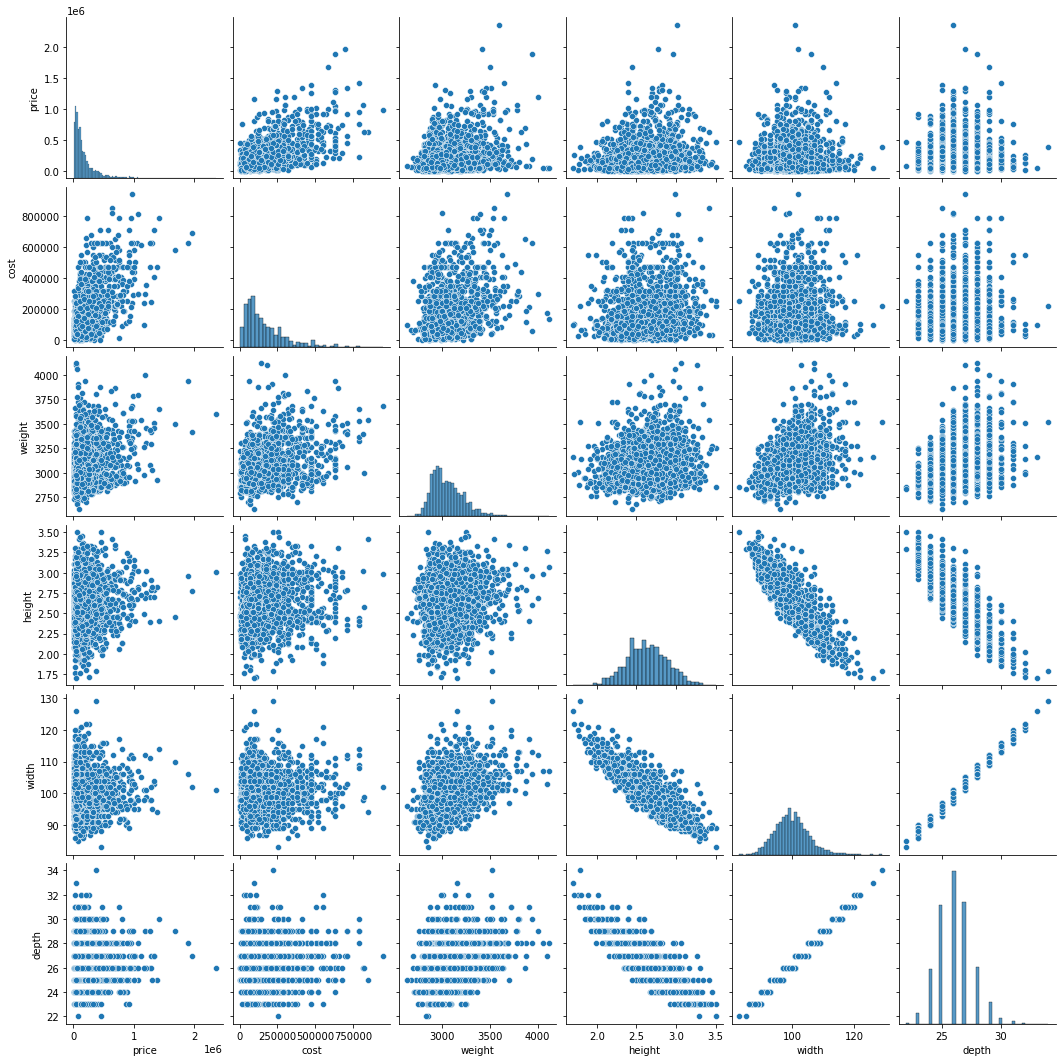

In [19]:
sns.pairplot(train)

<font color='red'>Question:</font> Which features are highly correlated?

### Highly correlated: width vs depth
### Highly negative-correlated: height vs width, height vs depth
### reasonably correlated: price vs cost

# 2. Collinearity

<font color='red'>Assignment:</font> Build a transformer class to get numerical features and replace the missing values with the averages in train_raw.

In [20]:
class Transformer(object):
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        df['weight'] = X.weight.map(self.weight2num)
        df['height'] = X.height.map(self.height2num)
        df['width'] = X.width.map(self.width2num)
        df['depth'] = X.depth.map(self.depth2num)
        self.mean = df.mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        df['weight'] = X.weight.map(self.weight2num)
        df['height'] = X.height.map(self.height2num)
        df['width'] = X.width.map(self.width2num)
        df['depth'] = X.depth.map(self.depth2num)
        return df.fillna(self.mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def cost2num(self, x):
        if type(x) == str: 
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x
    
    def height2num(self, x):
        if type(x) == str: 
            x = x.strip(' meters')
            return float(x)
        else:
            return x
    
    def width2num(self, x):
        if type(x) == str: 
            x = x.strip(' cm')
            return float(x)
        else:
            return x
        
    def depth2num(self, x):
        if type(x) == str: 
            x = x.strip(' cm')
            return float(x)
        else:
            return x
        
    def weight2num(self, x):
        if type(x) == str:
            x = x.strip("Kg").replace(" ", "").split("Ton")
            return float(x[0])*1000 + float(x[1])
        else:
            return x

### <font color='red'>Q:</font> another weightToNum, do you see any issue?

In [21]:
    def weightToNum(self, x):
        xList = []
        ton = 0
        kg = 0
        if type(x) == str:
            xList = x.split(' ')
        if xList:
            ton = float(xList[0])
            kg = float(xList[2])
        return ton * 1000 + kg

In [22]:
Tf = Transformer()

In [23]:
Tf.fit_transform(train_raw)

,cost,weight,height,width,depth
0,333000.000000,3090.0,2.76,97.0,26.0
1,166184.183143,3030.0,2.67,98.0,26.0
2,270000.000000,3040.0,3.00,93.0,24.0
4,97000.000000,2970.0,2.47,101.0,26.0
5,59000.000000,2930.0,2.71,96.0,25.0
...,...,...,...,...,...
3190,254000.000000,3040.0,2.02,113.0,30.0
3191,91000.000000,2890.0,2.52,99.0,26.0
3193,166184.183143,2830.0,2.15,106.0,28.0
3195,44000.000000,2950.0,2.52,100.0,26.0


In [24]:
Tf.transform(test_raw).head()

,cost,weight,height,width,depth
3,166184.183143,3050.0,2.50,102.0,27.0
10,160000.000000,3440.0,2.91,100.0,26.0
22,160000.000000,3120.0,2.93,95.0,25.0
23,166184.183143,2980.0,2.14,109.0,28.0
50,18000.000000,3210.0,2.58,103.0,27.0


<font color='red'>Assignment:</font> Wrap up the numerical transformer, MinMaxScaler, and linear regression as a pipeline to predict **price**. 

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [26]:
features = list(train_raw.columns)
target = 'price'
features.remove(target)

In [27]:
def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

In [28]:
X_train = train_raw[features]
y_train = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

In [29]:
(y_test.shape, X_test.shape)

((429,), (429, 11))

In [30]:
steps = [('ctf', Transformer()),
         ('rescale', MinMaxScaler()),
         ('lr', LinearRegression())]
model = Pipeline(steps)
model = model.fit(X_train, y_train)

In [31]:
y_train_pred = model.predict(X_train)

In [32]:
y_test_pred = model.predict(X_test)
print(X_test.shape, y_test_pred.shape)

(429, 11) (429,)


<font color='red'>Assignment:</font> Obtain the training and testing scores. 

In [33]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.14e+05
train MSE: 2.87e+10
train R2: 0.327


In [34]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.43e+05
test MSE: 5.58e+10
test R2: 0.353


<font color='red'>Assignment:</font> Plot the feature importance. Hint: coefficients in linear regression. 

In [35]:
coef = model.steps[2][1].coef_

In [36]:
coef

array([ 849256.84398592,  308400.89745442,  -60075.41776479,
       -207685.67433174,   83403.24130903])

In [37]:
import matplotlib.pylab as plt
%matplotlib inline

<BarContainer object of 5 artists>

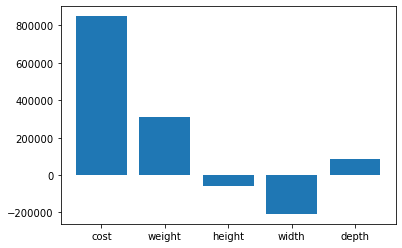

In [38]:
plt.bar(['cost', 'weight', 'height', 'width', 'depth'], coef)

In [39]:
train_raw['weight'].isnull().sum()

1

### with the incorrect data transfomer, only 1 weight value is different, but the coefficients change a lot

right transformation: [3.1, 3.2, 3.3, NaN] transformed to [3.1, 3.2, 3.3, 3.2]

wrong transformation: [3.1, 3.2, 3.3, NaN] transformed to [3.1, 3.2, 3.3, 0]

![image.png](attachment:image.png)

<font color='red'>Question:</font> How do you explain these feature importance?

### <font color='red'>Q:</font> Do you trust the negative correlation between width/height and price? 

### * collinearity makes the coefficient (feature importance) erratic

### From the plot, it seems that cost is important for predicting price, the dimensions are somewhat related, however, weight is unrelated, which is contradictory to what we saw in the heatmap.

<font color='red'>Assignment:</font> Remove **volumn**, **width**, and **height**, repeat the above steps.

In [40]:
X_train_new = train_raw[['cost', 'weight']]
y_train_new = train_raw[target].map(price2num)

X_test_new = test_raw[['cost', 'weight']]
y_test_new = test_raw[target].map(price2num)

In [41]:
class Transformer_new(object):
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        df['weight'] = X.weight.map(self.weight2num)
        self.mean = df.mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        df['weight'] = X.weight.map(self.weight2num)
        return df.fillna(self.mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def cost2num(self, x):
        if type(x) == str: 
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x
        
    def weight2num(self, x):
        if type(x) == str:
            x = x.strip("Kg").replace(" ", "").split("Ton")
            return float(x[0])*1000 + float(x[1])
        else:
            return x
        
#     def weight2num(self, x):
#         xList = []
#         ton = 0
#         kg = 0
#         if type(x) == str:
#             xList = x.split(' ')
#         if xList:
#             ton = float(xList[0])
#             kg = float(xList[2])
#         return ton * 1000 + kg

In [42]:
Tf_new = Transformer()

In [43]:
steps_new = [('ctf', Transformer_new()),
         ('rescale', MinMaxScaler()), # Standard
         ('lr', LinearRegression())]
model_new = Pipeline(steps_new)
model_new = model_new.fit(X_train_new, y_train_new)

In [44]:
y_train_pred_new = model_new.predict(X_train_new)

In [45]:
y_test_pred_new = model_new.predict(X_test_new)

<font color='red'>Question:</font> What are the differences in training/testing scores and feature importance?

In [46]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train_new, y_train_pred_new)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train_new, y_train_pred_new)))
print('train R2: {0:.3f}'.format(r2_score(y_train_new, y_train_pred_new)))

train MAE: 1.14e+05
train MSE: 2.87e+10
train R2: 0.326


In [47]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test_new, y_test_pred_new)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test_new, y_test_pred_new)))
print('test R2: {0:.3f}'.format(r2_score(y_test_new, y_test_pred_new)))

test MAE: 1.43e+05
test MSE: 5.59e+10
test R2: 0.352


### the metric score almost the same as before 

In [48]:
coef_new = model_new.steps[2][1].coef_

In [49]:
coef_new

array([850490.70209178, 251057.25599684])

<BarContainer object of 2 artists>

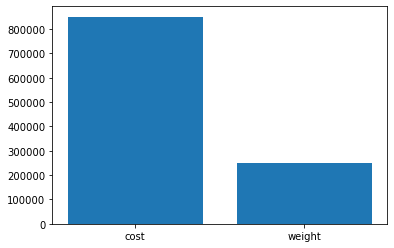

In [50]:
plt.bar(['cost', 'weight'], coef_new)

### if keeping depth
![image.png](attachment:image.png)

### <font color='red'>Q:</font> with the incorrect data transfomer, this time no multicollinearity, why weight feature_importance doubled?

right transformation: [3.1, 3.2, 3.3, NaN] transformed to [3.1, 3.2, 3.3, 3.2]

wrong transformation: [3.1, 3.2, 3.3, NaN] transformed to [3.1, 3.2, 3.3, 0]

![image.png](attachment:image.png)

### The error scores increased a bit but the good thing is that this time the weight is related to predicting the price, which is consistant with the heatmap.

<font color='red'>Question:</font> What is collinearity? How can we solve it?

### Colinearity happens when some of the features in the model are highly correlated. When features in the same regression model are correlated, they cannot independently predict the value of the dependent variable. In other words, they explain some of the same variance in the dependent variable, which in turn reduces their statistical significance.

### To get rid of colinearity, we can:
### (1) Remove highly correlated predictors from the model
### (2) Use PCA to cut off some features